# Warped Interpolation


In [1]:
import numpy as np
import matplotlib.pyplot as plt

Assume we have a set of points indexed by $(i,j)$ in 2D space for which we have corresponding functional values in a 3rd dimension, such that $f(x_{i,j},y_{i,j}) = z_{i,j}$. In practice, we are interested in cases where the $z_{ij}$ are difficult to compute and we are unable to compute them at other values of $x$ and $y$ -- which is why we want to interpolate. For the callibration below, we will generate these $z$'s arbitrarily using the function  

$$f(x,y) = (xy)^{1/4}$$

because the figures look good for our illustrations. 

These $(x_{i,j},y_{i,j})$ points however are not evenly spaced, and do not form a rectilinear grid which would make it easy to interpolate the function off the grid. Nevertheless, these points do have a regular structure as we will see.


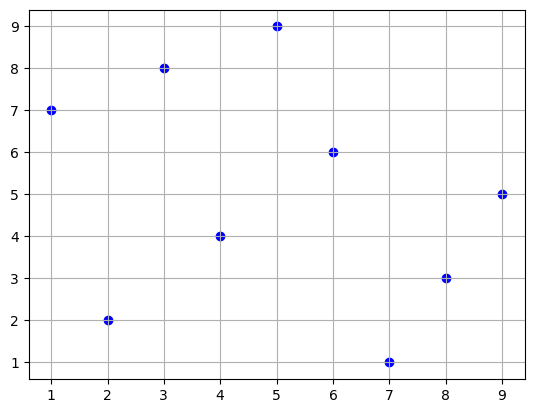

In [2]:
points = np.array(
    [[[1, 7], [3, 8], [5, 9]], [[2, 2], [4, 4], [6, 6]], [[7, 1], [8, 3], [9, 5]]]
).T
values = np.power(points[0] * points[1], 1 / 4)
plt.scatter(points[0], points[1], c="b")
plt.grid()


In the graph below, we can see the true function in 3D space, along with the points for which we actually know the value of the function.


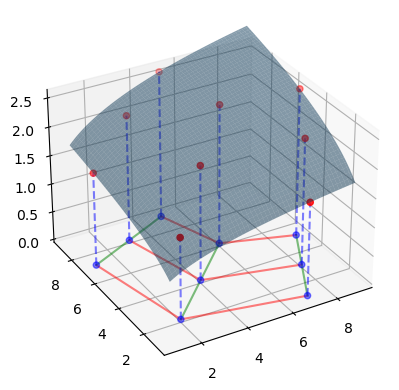

In [3]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(points[0], points[1], values, c="r")
ax.scatter(points[0], points[1], np.zeros_like(values), c="b", alpha=0.5)
for i in range(3):
    ax.plot(points[0, i], points[1, i], zs=0, zdir='z', c="r", alpha=0.5)
    ax.plot(points[0, :, i], points[1, :, i], zs=0, zdir='z', c="g", alpha=0.5)

for i in range(9):
    ax.plot(np.array([points[0].flat[i]]*2), np.array([points[1].flat[i]]
            * 2), [0, values.flat[i]], '--', c="b", alpha=0.5)


x = np.linspace(1, 9, 100)
xmat, ymat = np.meshgrid(x, x, indexing="ij")
zmat = np.power(xmat * ymat, 1 / 4)
ax.plot_surface(xmat, ymat, zmat, alpha=0.5)
ax.set_zlim(0, np.max(values))

ax.view_init(30, -120)

The underlying regular structure comes from the points' position in the matrix, the $(i,j)$ coordinates. If we join the points along every row and every column, we can see that the resulting grid is regular and piecewise affine (curvilinear).


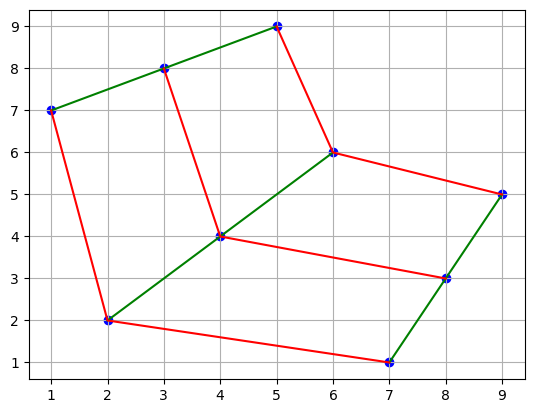

In [4]:
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.grid()

As we can see, this curvilinear grid can be easily transformed into a rectilinear grid by using the coordinate values $(i,j)$ of the underlying matrix that contains the values. For interpolation, this rectilinear grid allows us to use the standard fast interpolation methods available in SciPy.


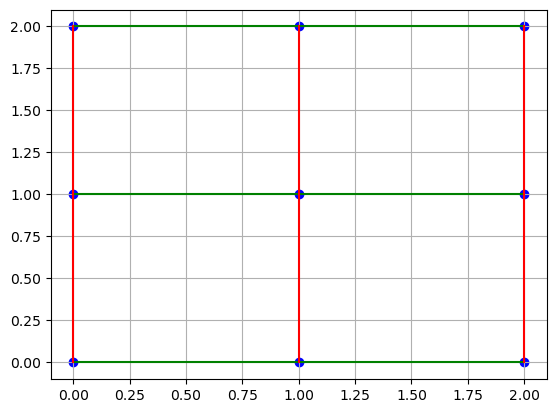

In [5]:
coord_points = np.mgrid[0:3, 0:3]
plt.scatter(coord_points[0], coord_points[1], c="b")
plt.plot(coord_points[0], coord_points[1], "g")
plt.plot(coord_points[0].T, coord_points[1].T, "r")
plt.grid()

Below we graph values of the function at their index coordinate points in the matrix. 

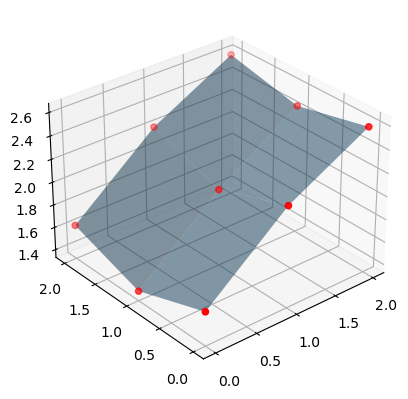

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(coord_points[0], coord_points[1], values, alpha=0.5)
ax.view_init(30, -130)

ax.scatter(coord_points[0], coord_points[1], values, c="r")


The objective is to be able to interpolate the value of the function at any point off the grid, where presumably we are only interested in points internal to the curvilinear space and not outside the boundaries. For example, we can imagine that we want an approximation to the function at the point $(x,y) = (3, 5)$ pictured below. If we could find the correspoinding point in the coordinate grid, interpolation would be straightforward.


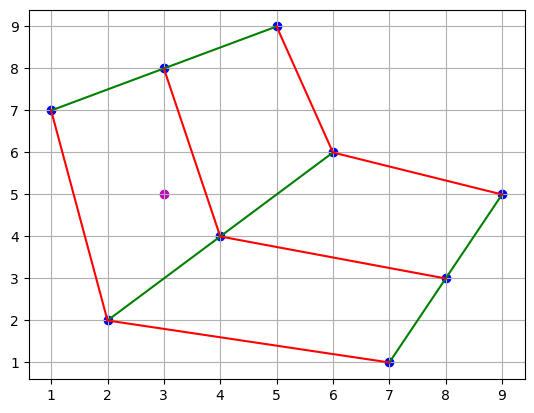

In [7]:
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.scatter(3, 5, c="m")
plt.grid()

### Method 1: Quad Interpolation

A straightforward and generalizable approach would be to identify the quadrilateral in which the point lies, and then use quad interpolation to find the corresponding z-value.

Quad interpolation consists of finding the affine transformation that maps the quadrilateral to the unit square, and then applying the transformation to the point of interest. Having located the corresponding point in the unit square, we can use standard bilinear interpolation to find the corresponding z-value.

![Quad Interpolation](https://www.particleincell.com/wp-content/uploads/2012/06/mapping-small.png)
![Quad Interpolation](https://www.particleincell.com/wp-content/uploads/2012/06/interpolation-300x279.png)

This approach is generalizable to any number of dimensions, and it is desirable for our purposes. However, we have not found a general tool in the Scientific Python environment that would allow us to do this.

This appears possible in other proprietary software but we have not found an open source tool that would allow us to do this.


### Method 2:

We can find where the x-coordinate of the point of interest intersects with the index-coordinates of the matrix.


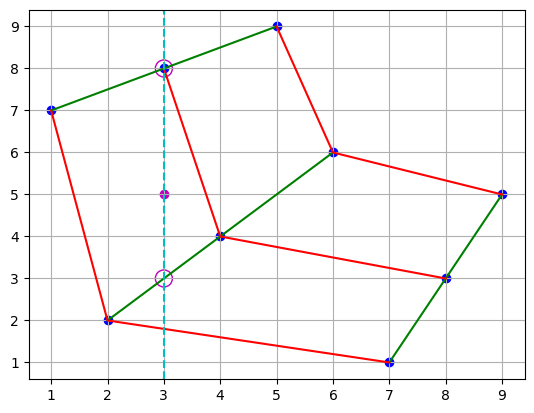

In [8]:
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.scatter(3, 5, c="m")
plt.scatter([3, 3], [3, 8], s=150, facecolors="none", edgecolors="m")
plt.axvline(x=3, color="c", linestyle="--")
plt.grid()

This is similar to assuming that we have 3 linear interpolators formed by connecting the points on the green lines in the x-direction, and for each interpolator we can approximate the corresponding y and z values using the grid data.


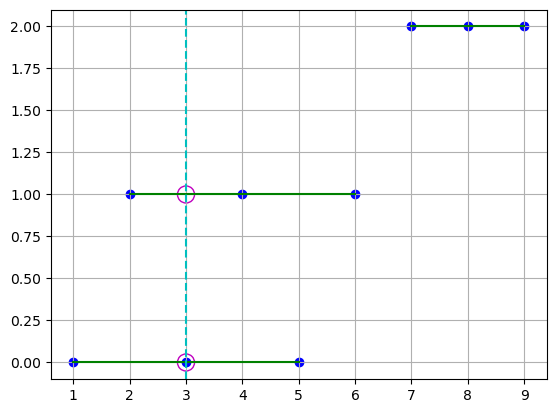

In [9]:
plt.scatter(points[0], coord_points[1], c="b")
plt.plot(points[0], coord_points[1], "g")
plt.axvline(x=3, color="c", linestyle="--")
plt.scatter([3, 3], [0, 1], s=150, facecolors="none", edgecolors="m")
plt.grid()

Now, for each circle in the figure, we have a corresponding pair $(y,z)$, and we can interpolate in the y-direction to find the corresponding z-value for the point's y-coordinate.


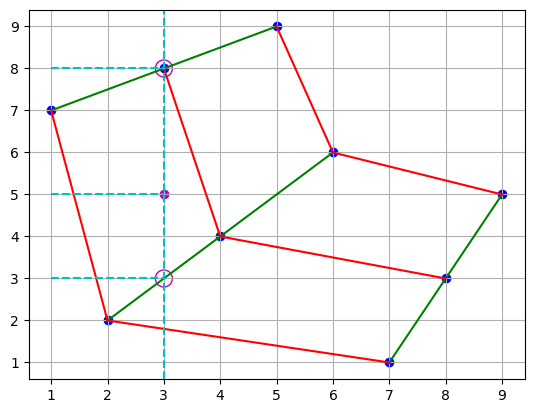

In [10]:
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.scatter(3, 5, c="m")
plt.scatter([3, 3], [3, 8], s=150, facecolors="none", edgecolors="m")
plt.axvline(x=3, color="c", linestyle="--")
plt.hlines(y=[3, 5, 8], xmin=1, xmax=3, color="c", linestyle="--")
plt.grid()

We can do the same by connecting the points on the red line, and interpolating $(y, z)$ values for the point's x-coordinate.


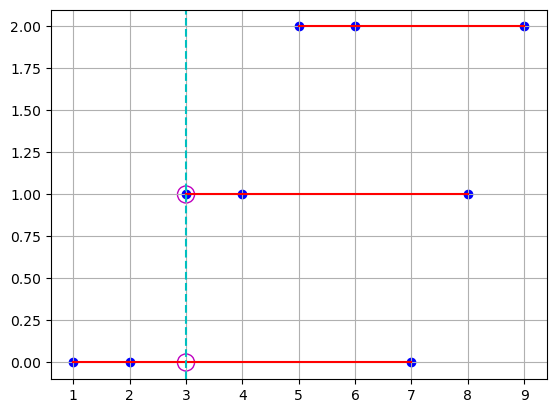

In [11]:
plt.scatter(points[0], coord_points[1].T, c="b")
plt.plot(points[0].T, coord_points[1], "r")
plt.axvline(x=3, color="c", linestyle="--")
plt.scatter([3, 3], [0, 1], s=150, facecolors="none", edgecolors="m")
plt.grid()


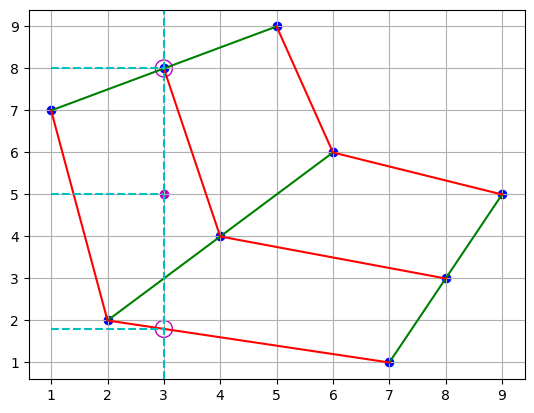

In [12]:
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.scatter(3, 5, c="m")
plt.scatter([3, 3], [1.8, 8], s=150, facecolors="none", edgecolors="m")
plt.axvline(x=3, color="c", linestyle="--")
plt.hlines(y=[1.8, 5, 8], xmin=1, xmax=3, color="c", linestyle="--")
plt.grid()

However, the two processes might provide different results. The differences in results arises from the values that are weighted in the interpolation. In the first case, interpolation uses the values that correspond to the quadrangle in which the point of interest lies. In the second case, the lowest cirle lies in an adjacent quadrangle, meaning that the $y$ and $z$ values corresponding to that point come from interpolation in the adjacent quadrangle. Because of this, the second result is weighing values that are further away from the point of interest, and the result is less accurate.

Additionally, we could start this method in the y-direction, and the results could be different yet.


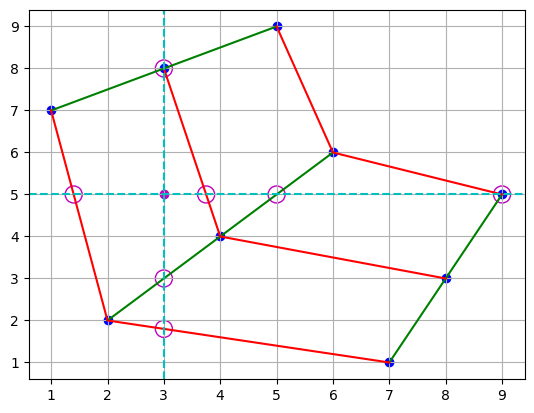

In [13]:
plt.scatter(points[0], points[1], c="b")
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.scatter(3, 5, c="m")
plt.axvline(x=3, color="c", linestyle="--")
plt.axhline(y=5, color="c", linestyle="--")
plt.scatter([3, 3, 3], [1.8, 3, 8], s=150, facecolors="none", edgecolors="m")
plt.scatter([1.4, 3.75, 5, 9], [5, 5, 5, 5], s=150,
            facecolors="none", edgecolors="m")
plt.grid()

### Method 3: Dense Interpolation

A third approach would be to use an interpolation method once (any of the above, or others), for the cross-product of all x and y coordinates, to create a rectilinear grid of $(x,y,z)$ values. Having done this, we can ignore the original curvilinear grid and use the rectilinear grid for interpolation. This method has the advantage of allowing us to interpolate in the original space and not in the warped space. 


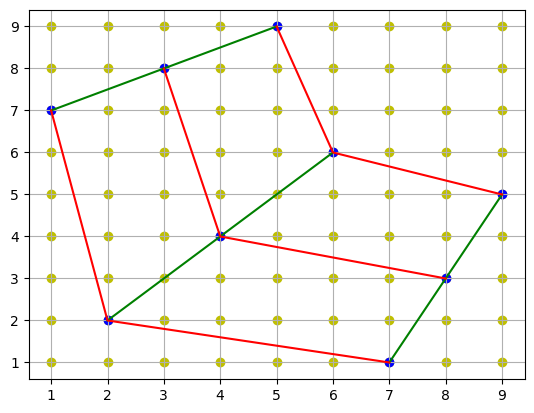

In [14]:
all_coords = np.mgrid[1:10, 1:10]
plt.plot(points[0], points[1], "g")
plt.plot(points[0].T, points[1].T, "r")
plt.scatter(all_coords[0], all_coords[1], c="y")
plt.scatter(points[0], points[1], c="b")
plt.grid()

As illustration, we can use `HARK.interpolation`'s `UnstructuredInterp` which wraps `scipy`'s unstructured interpolators (`griddata`). This method is not very fast, which is why we are looking for a faster alternative.

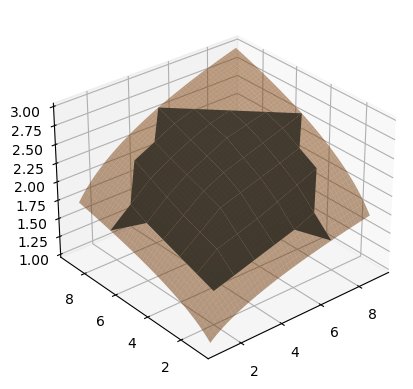

In [15]:
from HARK.interpolation import UnstructuredInterp

z_interp = UnstructuredInterp(values, [points[0], points[1]])
z_vals = z_interp(all_coords[0], all_coords[1])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(all_coords[0], all_coords[1], z_vals)
ax.plot_surface(xmat, ymat, zmat, alpha=0.5)
ax.view_init(30, -130)

# Why do we need other tools?

`scipy`'s unstructured interpolators (`griddata`) can be used to interpolate with curvilinear or piecewise affine grids, but they do so by discarding the underlying structure of the grid and instead producing a triangulation of the input points. This triangulation is comparatively slow, and discarding the structure also prevents us from using more fine grained information we may know about the function, such as its derivatives. 

An additional tool that we found useful is `scikit-image`'s `PiecewiseAffineTransform` which can be used to find the affine transformation that maps the curvilinear grid to a rectilinear grid. Again, however, this tool starts by creating a triangulation of the input points regardless of the structure of the grid. 

In our applications, we already have a structure to the grid that should be useful for interpolation. Namely, the index coordinate $(i,j)$ of the matrix that contains the values describes a grid that is piecewise affine and/or curvilinear. We would like to use this structure to speed up the interpolation process.

### Questions

1. Which method is the most accurate?
2. Which method is the fastest?
3. Are there other methods that could be used?
4. Do these methods generalize to higher dimensions?
